<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_03_28_jax_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT) in JAX


## Acknowledgement:
I borrowed some code from these resources:
- ViT architecture from [Scenic library](https://github.com/google-research/scenic/tree/main).
- The cifar10 preprocessing code from this github [repository](https://github.com/satojkovic/vit-jax-flax/tree/main) by satojkovic.
- [UvA Deep Learning Tutorials](https://github.com/phlippe/uvadlc_notebooks/tree/master).

## References:
```bibtex
@InProceedings{dehghani2021scenic,
    author    = {Dehghani, Mostafa and Gritsenko, Alexey and Arnab, Anurag and Minderer, Matthias and Tay, Yi},
    title     = {Scenic: A JAX Library for Computer Vision Research and Beyond},
    booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
    year      = {2022},
    pages     = {21393-21398}
}
```
```bibtex
@misc{dosovitskiy2021image,
  title         = {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
  author        = {Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby},
  year          ={2021},
  eprint        = {2010.11929},
  archivePrefix = {arXiv},
  primaryClass  = {cs.CV}
}
```

## Import libraries

In [ ]:
# install Scenic
!pip install -q git+https://github.com/google-research/scenic.git

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Javascript  # Restrict height of output cell.
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
import ml_collections
from jax.tree_util import tree_map
from flax.training import train_state
from scenic.model_lib.layers import attention_layers
from scenic.model_lib.layers import nn_layers

In [ ]:
from typing import Any, Callable, Optional, Sequence
Initializer = Callable[[jnp.ndarray, Sequence[int], jnp.dtype], jnp.ndarray]

## Hyper-parameters

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
CROP_SCALES = (0.8, 1.0)
CROP_RATIO = (0.9, 1.1)
SEED = 42

plt.style.use('dark_background')

## Positional Embeddings

In [ ]:
class AddPositionEmbs(nn.Module):
  """Adds learned positional embeddings to the inputs.

  Attributes:
    posemb_init: Positional embedding initializer.

  Returns:
    Output in shape `[bs, timesteps, in_dim]`.
  """
  posemb_init: Initializer = nn.initializers.normal(stddev=0.02)  # From BERT.

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    # Inputs.shape is (batch_size, seq_len, emb_dim).
    assert inputs.ndim == 3, ('Number of dimensions should be 3,'
                              ' but it is: %d' % inputs.ndim)
    pos_emb_shape = (1, inputs.shape[1], inputs.shape[2])
    pe = self.param('pos_embedding', self.posemb_init, pos_emb_shape,
                    inputs.dtype)
    return inputs + pe

## Transformer Encoder Layer

In [ ]:
class Encoder1DBlock(nn.Module):
  """Transformer encoder layer.

  Attributes:
    mlp_dim: Dimension of the mlp on top of attention block.
    num_heads: Number of self-attention heads.
    dtype: The dtype of the computation (default: float32).
    dropout_rate: Dropout rate.
    attention_dropout_rate: Dropout for attention heads.
    stochastic_depth: probability of dropping a layer linearly grows
      from 0 to the provided value.

  Returns:
    output after transformer encoder block.
  """
  mlp_dim: int
  num_heads: int
  dtype: Any = jnp.float32
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1
  stochastic_depth: float = 0.0

  @nn.compact
  def __call__(self, inputs: jnp.ndarray, deterministic: bool) -> jnp.ndarray:
    """Applies Encoder1DBlock module.

    Args:
      inputs: Input data.
      deterministic: Deterministic or not (to apply dropout).

    Returns:
      Output after transformer encoder block.
    """
    # Attention block.
    assert inputs.ndim == 3
    x = nn.LayerNorm(dtype=self.dtype)(inputs)
    x = nn.MultiHeadDotProductAttention(
        num_heads=self.num_heads,
        dtype=self.dtype,
        kernel_init=nn.initializers.xavier_uniform(),
        broadcast_dropout=False,
        deterministic=deterministic,
        dropout_rate=self.attention_dropout_rate)(x, x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic)
    # Performs layer-dropout (also known as stochastic depth)
    x = nn_layers.StochasticDepth(rate=self.stochastic_depth)(x, deterministic)
    x = x + inputs

    # MLP block.
    y = nn.LayerNorm(dtype=self.dtype)(x)
    y = attention_layers.MlpBlock(
        mlp_dim=self.mlp_dim,
        dtype=self.dtype,
        dropout_rate=self.dropout_rate,
        activation_fn=nn.gelu,
        kernel_init=nn.initializers.xavier_uniform(),
        bias_init=nn.initializers.normal(stddev=1e-6))(
            y, deterministic=deterministic)
    # Performs layer-dropout (also known as stochastic depth)
    y = nn_layers.StochasticDepth(rate=self.stochastic_depth)(y, deterministic)
    return y + x

## Transformer Encoder

In [ ]:
class Encoder(nn.Module):
  """Transformer Encoder.

  Attributes:
    num_layers: Number of layers.
    mlp_dim: Dimension of the mlp on top of attention block.
    num_heads: The number of heads for multi-head self-attention.
    positional_embedding: The type of positional embeddings to add to the
      input tokens. Options are {learned_1d, sinusoidal_2d, none}.
    dropout_rate: Dropout rate.
    stochastic_depth: probability of dropping a layer linearly grows
      from 0 to the provided value. Our implementation of stochastic depth
      follows timm library, which does per-example layer dropping and uses
      independent dropping patterns for each skip-connection.
    dtype: Dtype of activations.
    has_cls_token: Whether or not the sequence is prepended with a CLS token.
  """
  num_layers: int
  mlp_dim: int
  num_heads: int
  positional_embedding: str = 'learned_1d'
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1
  stochastic_depth: float = 0.0
  dtype: Any = jnp.float32
  has_cls_token: bool = False

  @nn.compact
  def __call__(self, inputs: jnp.ndarray, *, train: bool = False):
    """Applies Transformer model on the inputs.

    Args:
      inputs: Input tokens of shape [batch, num_tokens, channels].
      train: If in training mode, dropout and stochastic depth is applied.

    Returns:
      Encoded tokens.
    """

    assert inputs.ndim == 3  # Shape is `[batch, len, emb]`.
    dtype = jax.dtypes.canonicalize_dtype(self.dtype)

    # Add positional embeddings to tokens.
    if self.positional_embedding == 'learned_1d':
      x = AddPositionEmbs(
          posemb_init=nn.initializers.normal(stddev=0.02),  # from BERT.
          name='posembed_input')(
              inputs)
    elif self.positional_embedding == 'sinusoidal_1d':
      x = attention_layers.Add1DPositionEmbedding(posemb_init=None)(inputs)
    elif self.positional_embedding == 'sinusoidal_2d':
      batch, num_tokens, hidden_dim = inputs.shape
      if self.has_cls_token:
        num_tokens -= 1
      height = width = int(np.sqrt(num_tokens))
      if height * width != num_tokens:
        raise ValueError('Input is assumed to be square for sinusoidal init.')
      if self.has_cls_token:
        inputs_reshape = inputs[:, 1:].reshape(
            [batch, height, width, hidden_dim]
        )
        # Provides a fixed position encoding for 2D and 3D coordinates
        x = attention_layers.AddFixedSinCosPositionEmbedding()(inputs_reshape)
        x = x.reshape([batch, num_tokens, hidden_dim])
        x = jnp.concatenate([inputs[:, :1], x], axis=1)
      else:
        inputs_reshape = inputs.reshape([batch, height, width, hidden_dim])
        # Provides a fixed position encoding for 2D and 3D coordinates
        x = attention_layers.AddFixedSinCosPositionEmbedding()(inputs_reshape)
        x = x.reshape([batch, num_tokens, hidden_dim])
    elif self.positional_embedding == 'none':
      x = inputs
    else:
      raise ValueError('Unknown positional embedding: '
                       f'{self.positional_embedding}')
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)

    # Input Encoder.
    for lyr in range(self.num_layers):
      x = Encoder1DBlock(
          mlp_dim=self.mlp_dim,
          num_heads=self.num_heads,
          dropout_rate=self.dropout_rate,
          attention_dropout_rate=self.attention_dropout_rate,
          stochastic_depth=(lyr / max(self.num_layers - 1, 1))
          * self.stochastic_depth,
          name=f'encoderblock_{lyr}',
          dtype=dtype,
      )(x, deterministic=not train)
    encoded = nn.LayerNorm(name='encoder_norm')(x)
    return encoded

## ViT

In [ ]:
class ViT(nn.Module):
  """Vision Transformer model.

    Attributes:
    num_classes: Number of output classes.
    mlp_dim: Dimension of the mlp on top of attention block.
    num_layers: Number of layers.
    num_heads: Number of self-attention heads.
    patches: Configuration of the patches extracted in the stem of the model.
    hidden_size: Size of the hidden state of the output of model's stem.
    positional_embedding: The type of positional embeddings to add to the
      tokens at the beginning of the transformer encoder. Options are
      {learned_1d, sinusoidal_2d, none}.
    representation_size: Size of the representation layer in the model's head.
      if None, we skip the extra projection + tanh activation at the end.
    dropout_rate: Dropout rate.
    attention_dropout_rate: Dropout for attention heads.
    classifier: type of the classifier layer. Options are 'gap', 'gmp', 'gsp',
      'token', 'none'.
    dtype: JAX data type for activations.
  """

  num_classes: int
  mlp_dim: int
  num_layers: int
  num_heads: int
  # ConfigDict is a "dict-like" data structures with dot access to nested elements
  patches: ml_collections.ConfigDict
  hidden_size: int
  positional_embedding: str = 'learned_1d'
  representation_size: Optional[int] = None
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1
  stochastic_depth: float = 0.0
  classifier: str = 'gap'
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, *, train: bool = False, debug: bool = False):

    fh, fw = self.patches.size
    # Extracting patches and then embedding is in fact a single convolution.
    x = nn.Conv(
        self.hidden_size, (fh, fw),
        strides=(fh, fw),
        padding='VALID',
        name='embedding')(
            x)
    n, h, w, c = x.shape
    x = jnp.reshape(x, [n, h * w, c])

    # If we want to add a class token, add it here.
    if self.classifier == 'token':
      cls = self.param('cls', nn.initializers.zeros, (1, 1, c), x.dtype)
      cls = jnp.tile(cls, [n, 1, 1])
      x = jnp.concatenate([cls, x], axis=1)

    x = Encoder(
        mlp_dim=self.mlp_dim,
        num_layers=self.num_layers,
        num_heads=self.num_heads,
        positional_embedding=self.positional_embedding,
        dropout_rate=self.dropout_rate,
        attention_dropout_rate=self.attention_dropout_rate,
        stochastic_depth=self.stochastic_depth,
        dtype=self.dtype,
        has_cls_token=self.classifier == 'token',
        name='Transformer',
    )(x, train=train)

    if self.classifier in ('token', '0'):
      x = x[:, 0]
    elif self.classifier in ('gap', 'gmp', 'gsp'):
      fn = {'gap': jnp.mean, 'gmp': jnp.max, 'gsp': jnp.sum}[self.classifier]
      x = fn(x, axis=1)
    elif self.classifier == 'map':
      x = MAPHead(
          num_heads=self.num_heads, mlp_dim=self.mlp_dim, dtype=self.dtype)(x)
    elif self.classifier == 'none':
      pass
    else:
      raise ValueError(f'Unknown classifier {self.classifier}')

    if self.representation_size is not None:
      x = nn.Dense(self.representation_size, name='pre_logits')(x)
      x = nn.tanh(x)
    else:
      x = nn_layers.IdentityLayer(name='pre_logits')(x)

    if self.num_classes > 0:
      # If self.num_classes <= 0, we just return the backbone features.
      x = nn.Dense(
          self.num_classes,
          name='output_projection')(
              x)
    return x

## Notes on ViT Architecture

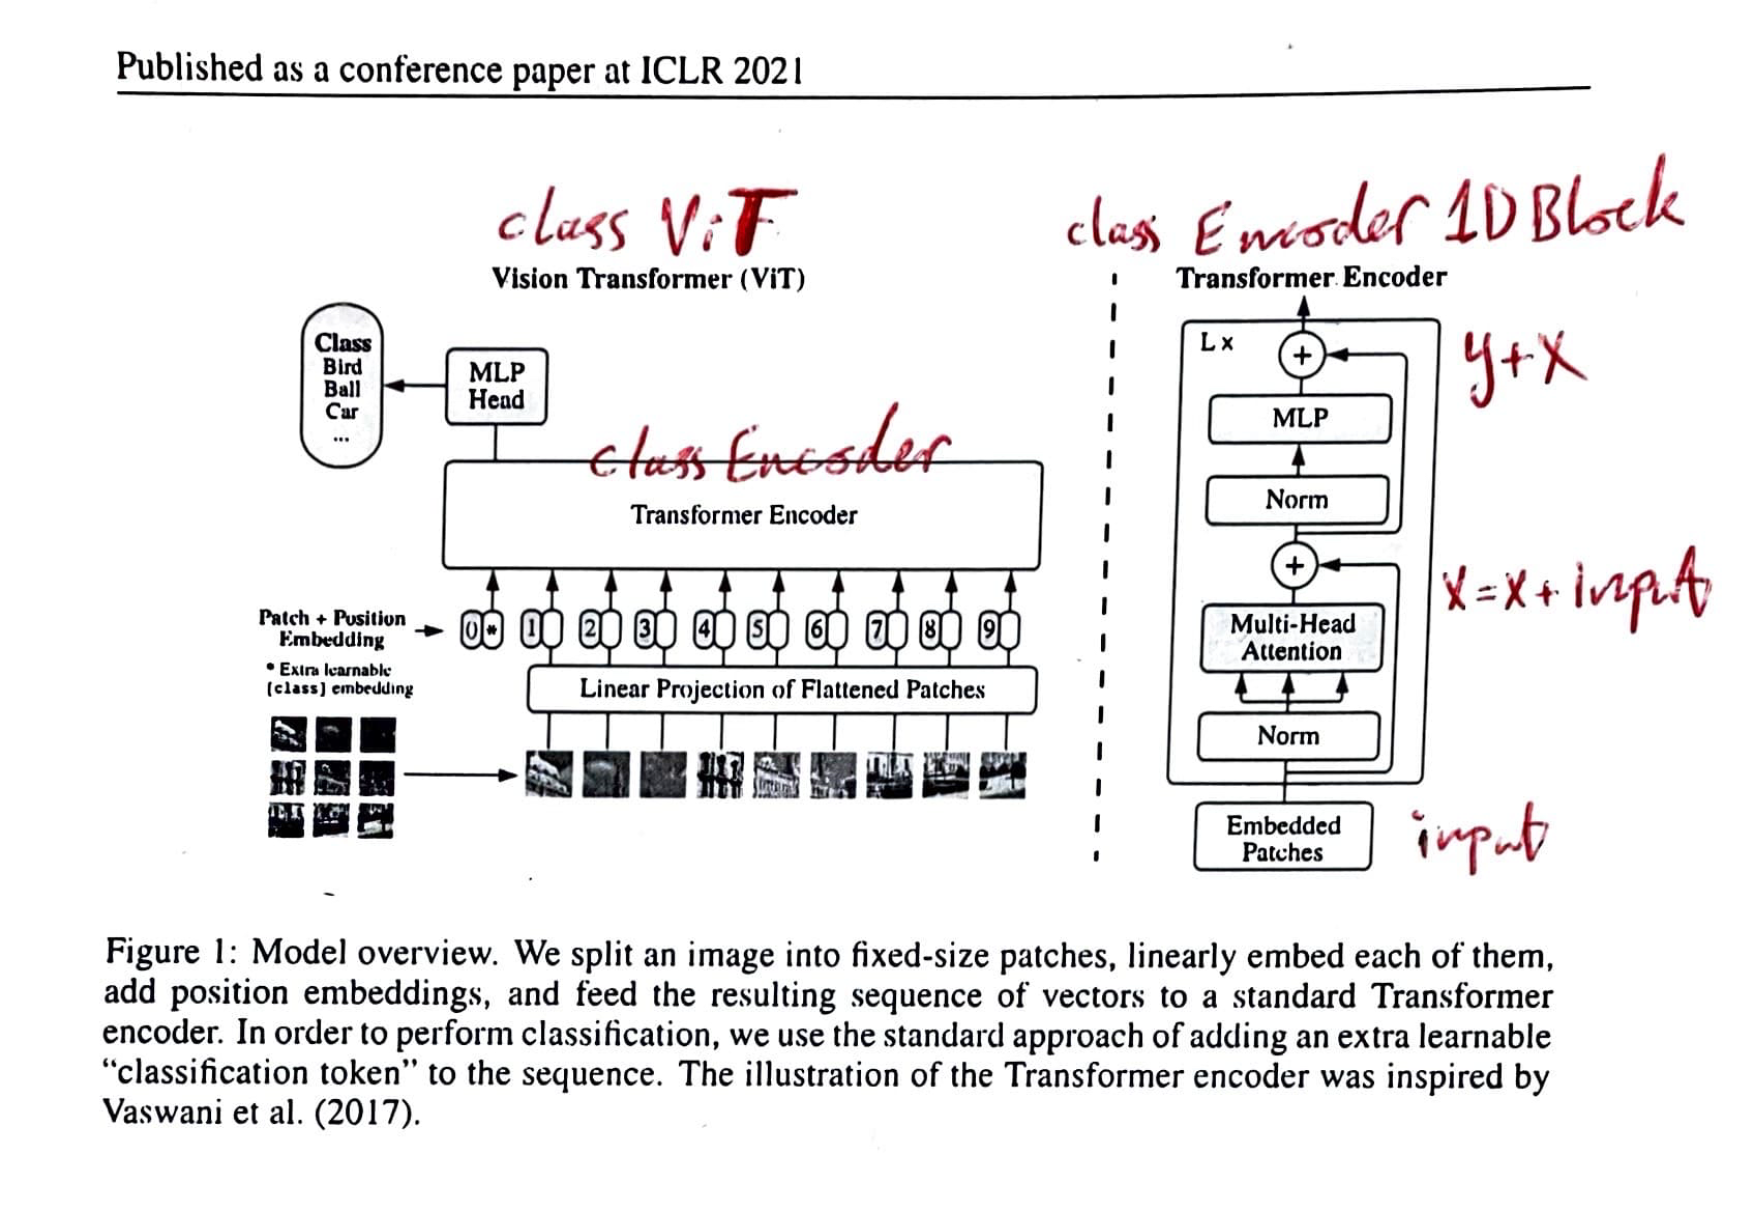

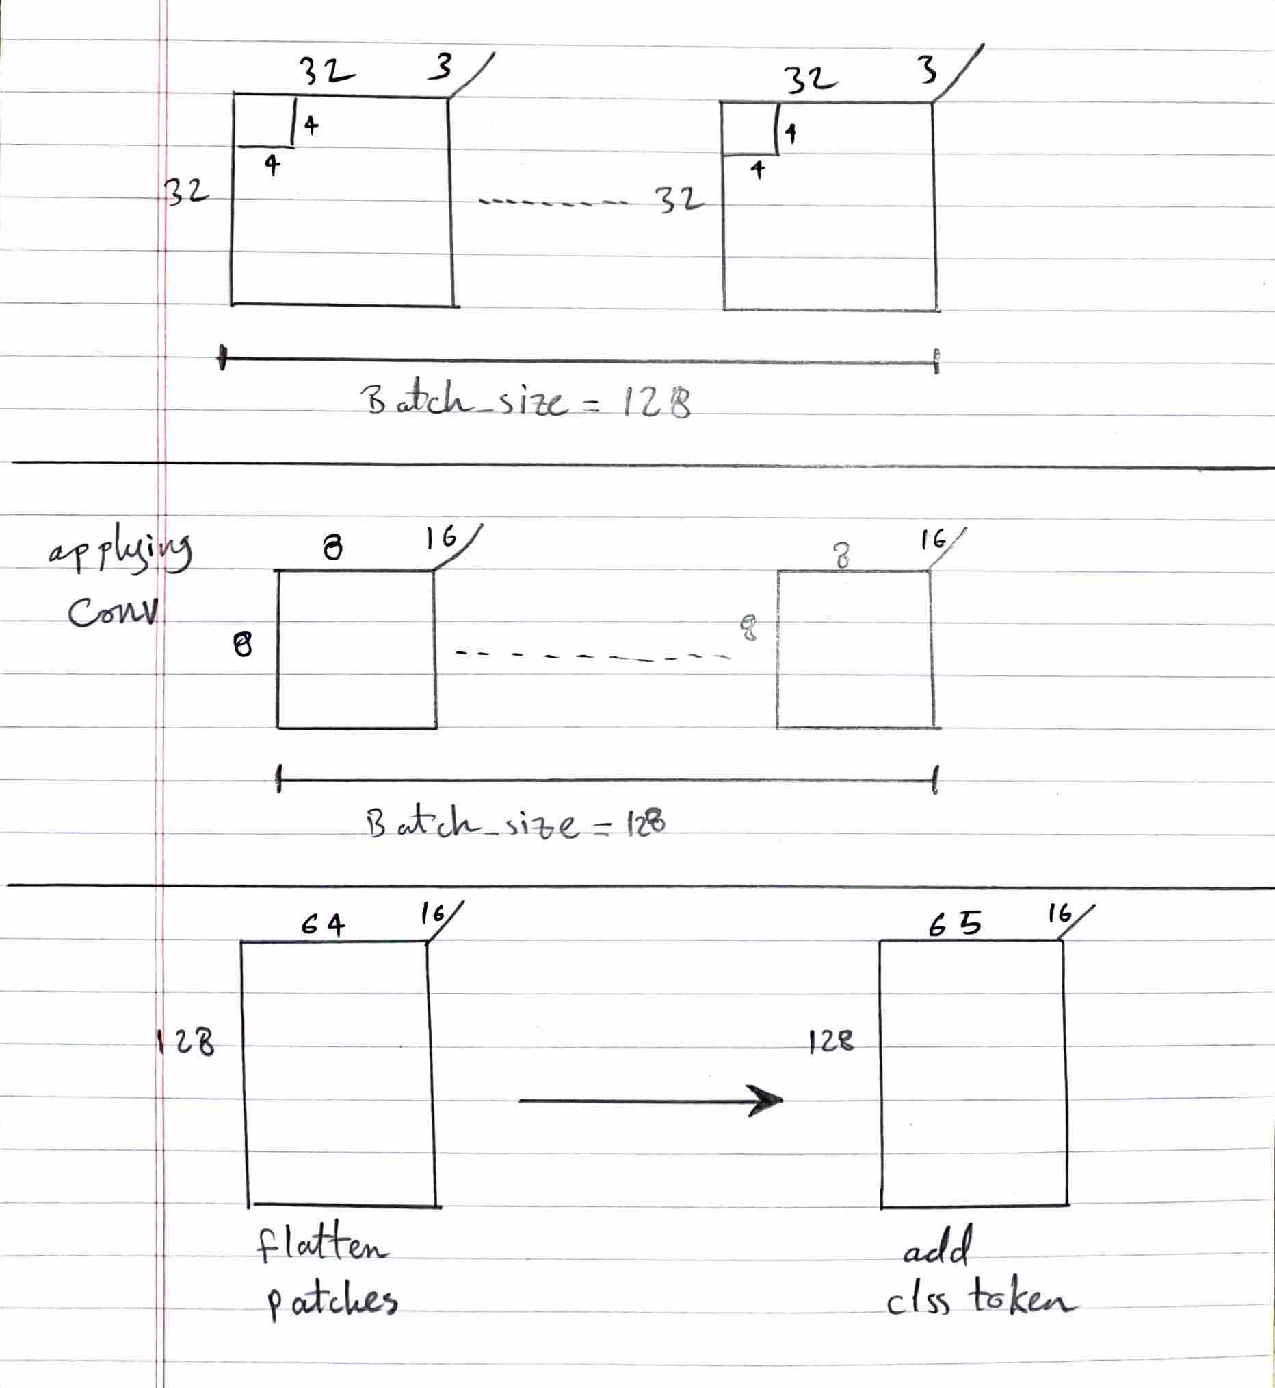

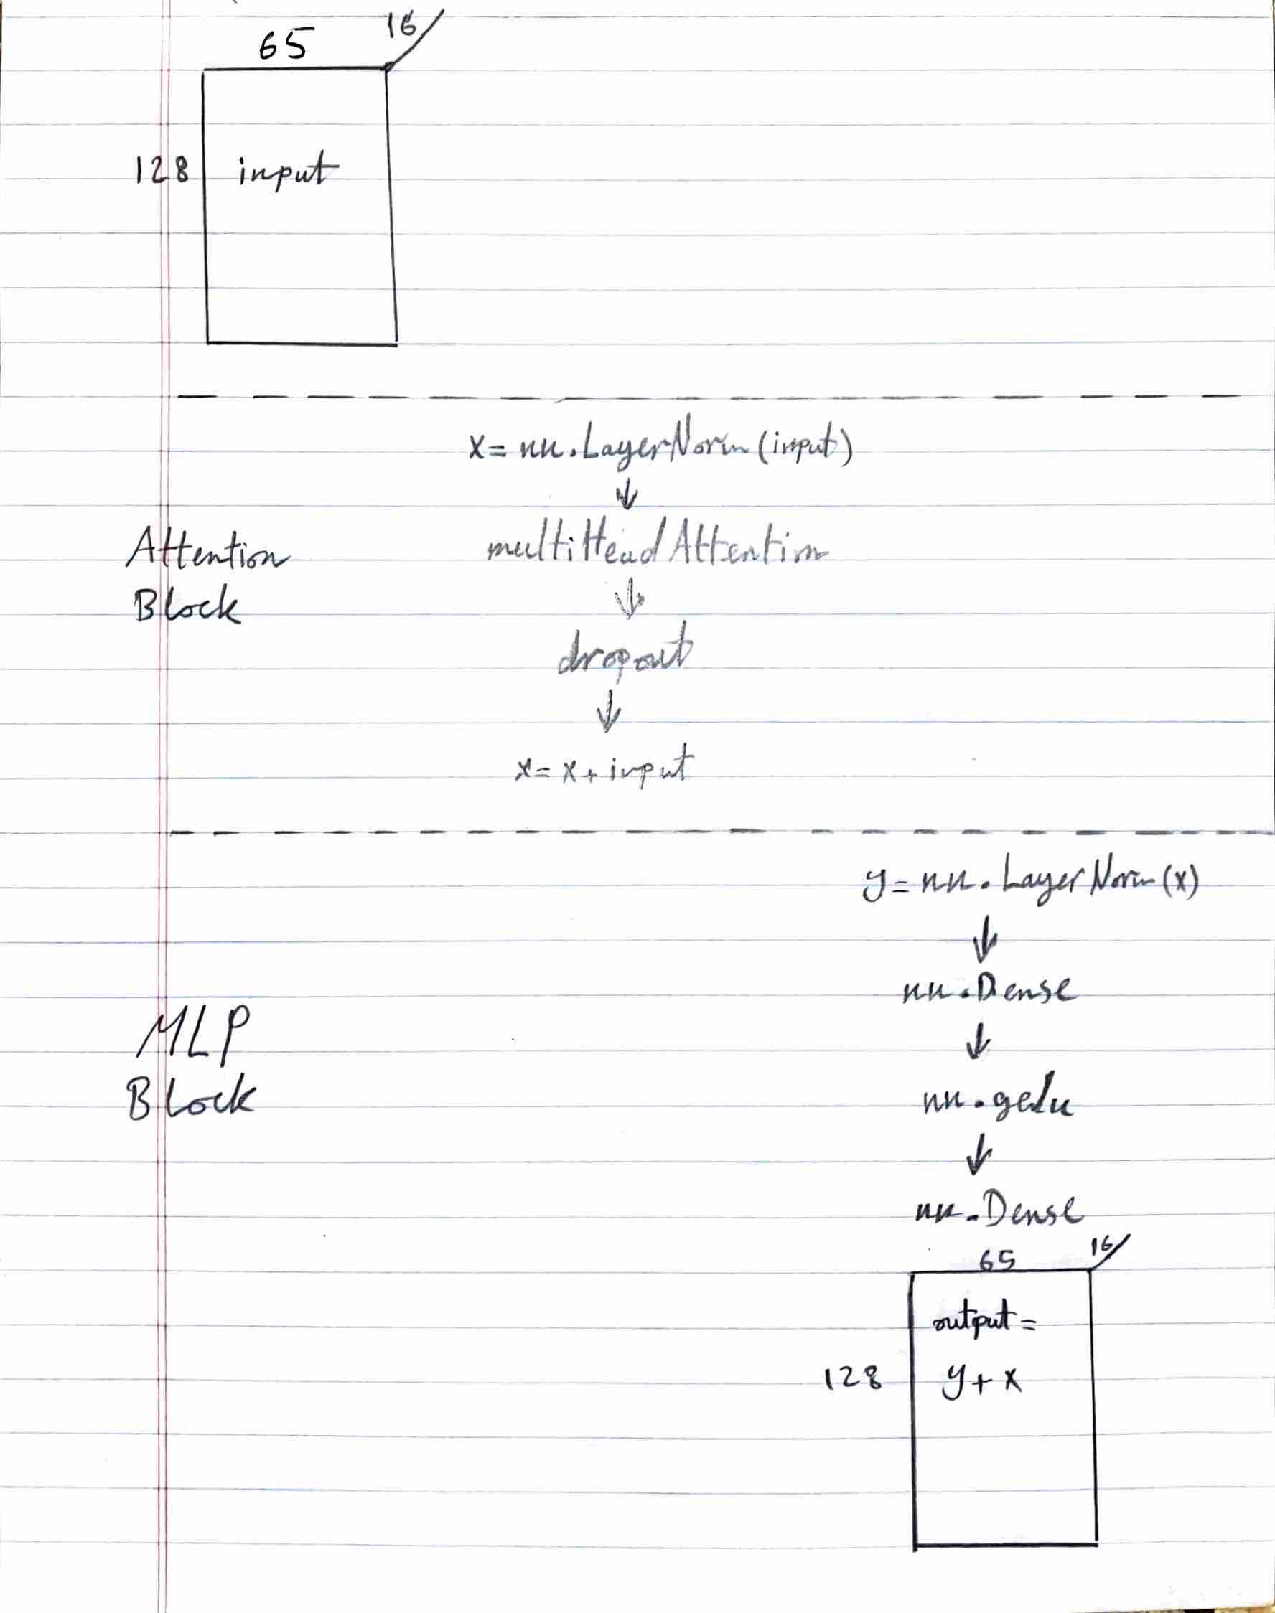

## Load CIFAR10 Dataset

In [ ]:
# A helper function that normalizes the images between the values specified by the hyper-parameters.
def image_to_numpy(img):
  img = np.array(img, dtype=np.float32)
  img = (img / 255. - DATA_MEANS) / DATA_STD
  return img

In [ ]:
# A helper function that converts batches into numpy arrays instead of the default option which is torch tensors
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# images in the test set will only be converted into numpy arrays
test_transform = image_to_numpy
# images in the train set will be randomly flipped, cropped, and then converted to numpy arrays
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=CROP_SCALES, ratio=CROP_RATIO),
    image_to_numpy
])

# Validation set should not use train_transform.
train_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
test_set = torchvision.datasets.CIFAR10('data', train=False, transform=test_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
val_data_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
test_data_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('CHECK CHECK CHECK')
print(f'number of samples in train_set:         {len(train_set)}')
print(f'number of batches in train_data_loader: {len(train_data_loader)}')
print(f'number of samples / batch size:         {len(train_set)} / {BATCH_SIZE} = {len(train_set)/BATCH_SIZE}')
print(f'number of samples in test_set:          {len(test_set)}')
print(f'number of batches in test_data_loader:  {len(test_data_loader)}')
print(f'number of samples / batch size:         {len(test_set)} / {BATCH_SIZE} = {len(test_set)/BATCH_SIZE}')

CHECK CHECK CHECK
number of samples in train_set:         45000
number of batches in train_data_loader: 351
number of samples / batch size:         45000 / 128 = 351.5625
number of samples in test_set:          10000
number of batches in test_data_loader:  79
number of samples / batch size:         10000 / 128 = 78.125


In [ ]:
print(f'size of images in the first train batch: {next(iter(train_data_loader))[0].shape}')
print(f'type of images in the first train batch: {next(iter(train_data_loader))[0].dtype}')
print(f'size of labels in the first train batch: {next(iter(train_data_loader))[1].shape}')
print(f'type of labels in the first train batch: {next(iter(train_data_loader))[1].dtype}')

size of images in the first train batch: (128, 32, 32, 3)
type of images in the first train batch: float64
size of labels in the first train batch: (128,)
type of labels in the first train batch: int64


## Initializing The Model

In [ ]:
model = ViT(num_classes=len(classes),
            mlp_dim= 256,
            num_layers=6,
            num_heads=8,
            positional_embedding='learned_1d',
            patches=ml_collections.config_dict.FrozenConfigDict({'size': (4, 4)}),
            hidden_size= 128,
            classifier='token',
            dropout_rate=0.1,
            attention_dropout_rate=0.
    )

## Optimizer and Loss

In [ ]:
optimizer = optax.adam(learning_rate=1e-4)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(SEED), 3)
params = model.init(jax.random.PRNGKey(SEED),
                    jax.random.normal(inp_rng, (BATCH_SIZE, 32, 32, 3))
                    )

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def calculate_loss_acc(state, params, batch):
  data_input, labels = batch
  logits = state.apply_fn(params, data_input)
  pred_labels = jnp.argmax(logits, axis=1)
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[1])
  loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
  acc = (pred_labels == labels).mean()
  return loss, acc

## Training

In [ ]:
@jax.jit
def train_step(state, batch):
  # Gradient function
  grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

@jax.jit
def eval_step(state, batch):
  # Determine the accuracy
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

In [ ]:
def train_model(state, data_loader, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    all_losses, all_accs, batch_sizes = [], [], []
    for batch in data_loader:
      state, batch_loss, batch_acc = train_step(state, batch)
      all_losses.append(batch_loss)
      all_accs.append(batch_acc)
      batch_sizes.append(batch[0].shape[0])

    # Weighted average since some batches might be smaller
    loss = sum([a*b for a,b in zip(all_losses, batch_sizes)]) / sum(batch_sizes)
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f'epoch: {epoch:03d}, loss: {loss:.4f}, accuracy: {acc:.4f}')
  return state

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

<IPython.core.display.Javascript object>

epoch: 000, loss: 1.7730, accuracy: 0.3500
epoch: 001, loss: 1.5343, accuracy: 0.4422
epoch: 002, loss: 1.4312, accuracy: 0.4821
epoch: 003, loss: 1.3432, accuracy: 0.5157
epoch: 004, loss: 1.2855, accuracy: 0.5372
epoch: 005, loss: 1.2334, accuracy: 0.5584
epoch: 006, loss: 1.1926, accuracy: 0.5712
epoch: 007, loss: 1.1513, accuracy: 0.5883
epoch: 008, loss: 1.1181, accuracy: 0.6007
epoch: 009, loss: 1.0855, accuracy: 0.6080
epoch: 010, loss: 1.0511, accuracy: 0.6232
epoch: 011, loss: 1.0257, accuracy: 0.6353
epoch: 012, loss: 1.0058, accuracy: 0.6410
epoch: 013, loss: 0.9811, accuracy: 0.6478
epoch: 014, loss: 0.9554, accuracy: 0.6598
epoch: 015, loss: 0.9412, accuracy: 0.6650
epoch: 016, loss: 0.9174, accuracy: 0.6713
epoch: 017, loss: 0.9007, accuracy: 0.6804
epoch: 018, loss: 0.8856, accuracy: 0.6849
epoch: 019, loss: 0.8669, accuracy: 0.6899
epoch: 020, loss: 0.8497, accuracy: 0.6959
epoch: 021, loss: 0.8335, accuracy: 0.7033
epoch: 022, loss: 0.8229, accuracy: 0.7070
epoch: 023,

## Testing

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
all_losses, all_accs, batch_sizes = [], [], []
for batch in test_data_loader:
  batch_loss, batch_acc = calculate_loss_acc(trained_model_state, trained_model_state.params, batch)
  all_losses.append(batch_loss)
  all_accs.append(batch_acc)
  batch_sizes.append(batch[0].shape[0])

# Weighted average since some batches might be smaller
loss = sum([a*b for a,b in zip(all_losses, batch_sizes)]) / sum(batch_sizes)
acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

<IPython.core.display.Javascript object>

loss: 1.3897, accuracy: 0.6704


## Confusion Matrix

In [ ]:
all_labels, all_pred_labels = [], []
for i, batch in enumerate(test_data_loader):
  data_input, labels = batch
  logits = trained_model_state.apply_fn(trained_model_state.params, data_input)
  pred_labels = jnp.argmax(logits, axis=1)
  all_labels.append(labels)
  all_pred_labels.append(pred_labels)

all_labels_np = all_labels[0]
all_pred_labels_np = all_pred_labels[0]
for i in range(1,len(all_labels)):
  all_labels_np = np.concatenate((all_labels_np, all_labels[i]), axis=0)
  all_pred_labels_np = np.concatenate((all_pred_labels_np, all_pred_labels[i]), axis=0)

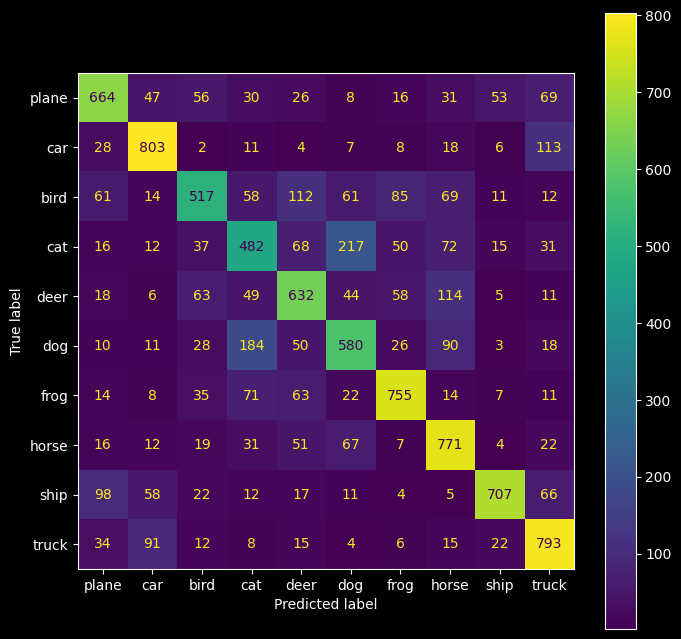

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(all_labels_np, all_pred_labels_np, display_labels=classes, ax=ax)
plt.show()